### import libraries

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as md
import torch
import pickle
from WeightedLDA import WeightedLDA as WL
from shapeGMMTorch import ShapeGMM
from shapeGMMTorch.utils import cross_validate_component_scan, sgmm_fit_with_attempts

output_folder = "outputs/generative"
os.makedirs(output_folder, exist_ok=True)
# if regenerate is false, clustering steps will be skipped if output files already exist
regenerate=False

### routine to compute dihedrals

In [10]:
from MDAnalysis.lib.distances import calc_dihedrals

def calc_phi_psi(trajData):
    phis = calc_dihedrals(trajData[:,0,:], trajData[:,1,:], trajData[:,2,:], trajData[:,3,:])*180/3.14
    psis = calc_dihedrals(trajData[:,1,:], trajData[:,2,:], trajData[:,3,:], trajData[:,4,:])*180/3.14
    return phis,psis

### load wsgmm objects trained on different data sets (3 clusters)

In [11]:
# trained on MD simulation data 
with open('outputs/clustering/wsgmm3.pickle', 'rb') as fo:
    wsgmm3_md = pickle.load(fo)
print(wsgmm3_md.weights_)


# trained on LD1 Metad data
with open('outputs/clustering_biased/wsgmm3_bias.pickle', 'rb') as fo:
    wsgmm3_ld1 = pickle.load(fo)
print(wsgmm3_ld1.weights_)


# trained on phi-psi MetaD data
#with open('./run_metad/bias_phi_psi/wsgmm3_bias_glen_data.pickle', 'rb') as fo:
#    wsgmm3_dih = pickle.load(fo)
#print(wsgmm3_dih.weights_)

[0.5        0.26400697 0.23599303]
[0.50623731 0.47674003 0.01702267]


### load wsgmm objects trained on different data sets (4 clusters)

In [12]:
## trained on MD simulation data 
#with open('wsgmm4.pickle', 'rb') as fo:
#    wsgmm4_md = pickle.load(fo)
#print(wsgmm4_md.weights_)


## trained on LD1 Metad data
#with open('wsgmm4_bias.pickle', 'rb') as fo:
#    wsgmm4_ld1 = pickle.load(fo)
#print(wsgmm4_ld1.weights_)


# trained on phi-psi MetaD data
#with open('./run_metad/bias_phi_psi/wsgmm4_bias_glen_data.pickle', 'rb') as fo:
#    wsgmm4_dih = pickle.load(fo)
#print(wsgmm4_dih.weights_)

### make 2d fes on dihedral space 

### compute metad refernce FES

Text(0, 0.5, '$\\psi$')

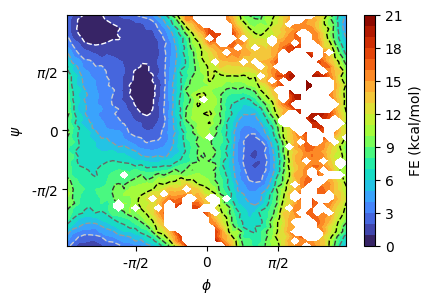

In [13]:
num_bins = 50
kt = 0.596161  # @ 300K in kcal/mol unit
path_file_ = '..//generate_data/metad_lda/bias_phipsi/alaA_100ns_biasphipsi_h0.5_sigma0.4_BF8.cv.dat'

phi_, psi_, meta_rbias = np.loadtxt(path_file_, usecols=(2,3,5), unpack=True)
phi_ *= 180/3.14
psi_ *= 180/3.14


hist, xedges, yedges = np.histogram2d(phi_, psi_, bins=num_bins, density=True, weights=np.exp(meta_rbias/kt))
xcenters = (xedges[1:]+xedges[:-1])/2
ycenters = (yedges[1:]+yedges[:-1])/2
xx, yy = np.meshgrid(xcenters, ycenters)
fe_ref = -kt*np.log(hist)
fe_ref -= fe_ref.min()

fig, ax = plt.subplots(1, 1, figsize=(4.5,3))
im = ax.contourf(xx, yy, fe_ref.T, cmap='turbo', levels=25)
ax.set_xticks([-90,0,90])
ax.set_xticklabels(["-$\pi/2$", 0, "$\pi/2$"])
ax.set_yticks([-90,0,90])
ax.set_yticklabels(["-$\pi/2$", 0, "$\pi/2$"])

ax.contour(xx, yy, fe_ref.T, cmap="binary", levels=np.arange(1,12,2), linestyles="--", linewidths=1.0)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('FE (kcal/mol)')
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')

In [14]:
# 3 clusters
#wsgmm_objs_list = [wsgmm3_md, wsgmm3_ld1, wsgmm3_dih]

wsgmm_objs_list = [wsgmm3_md, wsgmm3_ld1]

# 4 clusters
#wsgmm_objs_list = [wsgmm4_md, wsgmm4_ld1, wsgmm4_dih]

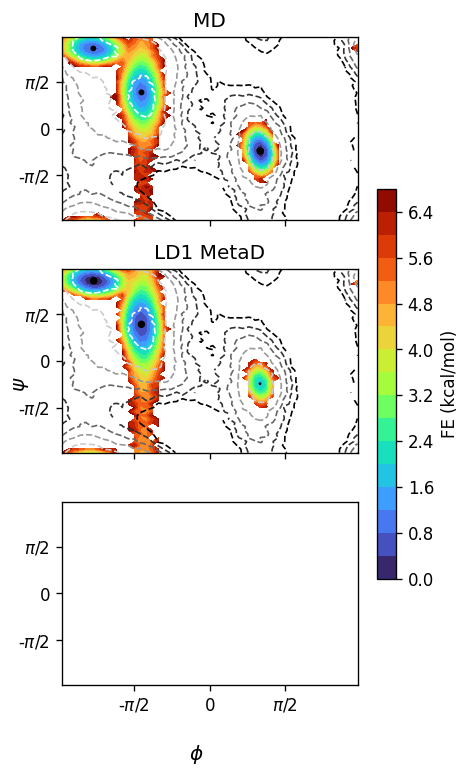

In [15]:
num_samples = 1000000

fig, axs = plt.subplots(3, 1, figsize=(3.2,6.5), sharex=True, sharey=True, dpi=120)
axs = axs.reshape([-1])
fig.supxlabel("$\phi$")
fig.supylabel("$\psi$")
titles = ["MD", "LD1 MetaD", "Dihedral MetaD"]


axs[0].set_xticks([-90,0,90])
axs[0].set_xticklabels(["-$\pi/2$", 0, "$\pi/2$"])
axs[0].set_yticks([-90,0,90])
axs[0].set_yticklabels(["-$\pi/2$", 0, "$\pi/2$"])

# loop over the sizes
for i in range(len(wsgmm_objs_list)):
        obj = wsgmm_objs_list[i]
        
        # generate samples 
        gen_trj = obj.generate(num_samples)
        
        # compute phi-psi for generated traj
        phi, psi = calc_phi_psi(gen_trj)
        
        # compute phi-psi for cluster centers 
        phi_centers, psi_centers = calc_phi_psi(obj.means_)
        
        # histogram
        hist, xedges, yedges = np.histogram2d(phi, psi, bins=num_bins, density=True)

        xcenters = (xedges[1:]+xedges[:-1])/2.0
        ycenters = (yedges[1:]+yedges[:-1])/2.0
        
        fe = -kt*np.log(hist)
        fe -= fe.min()
        
        axs[i].set_title(titles[i])
        im = axs[i].contourf(xcenters, ycenters, fe.T, cmap="turbo", levels=20)        
        axs[i].contour(xx, yy, fe_ref.T, cmap="binary", levels=np.arange(1,12,2), linestyles="--", linewidths=1.0)
        axs[i].scatter(phi_centers, psi_centers, marker="o", s=obj.weights_*25.0, color="k")

        
# Create a common colorbar
cbar_ax = fig.add_axes([0.97, 0.25, 0.05, 0.5])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)

# Optionally, add a label to the colorbar
cbar.set_label('FE (kcal/mol)')
#cbar.set_ticks(np.arange(0, 6, 0.5))
#cbar.set_ticklabels(np.arange(0, 6, 0.5))


fig.tight_layout()
fig.subplots_adjust(left=0.15, right=0.92)

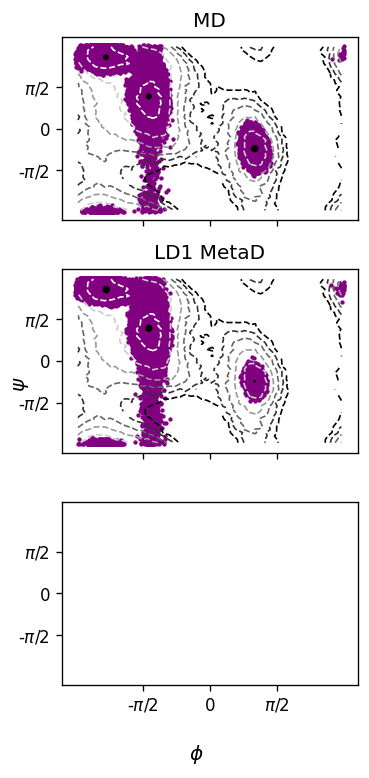

In [16]:
num_samples = 1000000

fig, axs = plt.subplots(3, 1, figsize=(3.2,6.5), sharex=True, sharey=True, dpi=120)
axs = axs.reshape([-1])
fig.supxlabel("$\phi$")
fig.supylabel("$\psi$")
titles = ["MD", "LD1 MetaD", "Dihedral MetaD"]


axs[0].set_xticks([-90,0,90])
axs[0].set_xticklabels(["-$\pi/2$", 0, "$\pi/2$"])
axs[0].set_yticks([-90,0,90])
axs[0].set_yticklabels(["-$\pi/2$", 0, "$\pi/2$"])

# loop over the sizes
for i in range(len(wsgmm_objs_list)):
        obj = wsgmm_objs_list[i]
        
        # generate samples 
        gen_trj = obj.generate(num_samples)
        
        # compute phi-psi for generated traj
        phi, psi = calc_phi_psi(gen_trj)
        
        # compute phi-psi for cluster centers 
        phi_centers, psi_centers = calc_phi_psi(obj.means_)
    
        
        axs[i].set_title(titles[i])
        im = axs[i].scatter(phi, psi, marker='.', s=10, color='purple')        
        axs[i].contour(xx, yy, fe_ref.T, cmap="binary", levels=np.arange(1,12,2), linestyles="--", linewidths=1.0)
        axs[i].scatter(phi_centers, psi_centers, marker="o", s=obj.weights_*25.0, color="k")
fig.tight_layout()
fig.subplots_adjust(left=0.15, right=0.92)